In [159]:
import subprocess
import os
import sys
import matplotlib.backends.backend_pdf
import scanpy as sc
import matplotlib.pyplot as pl
import anndata as ad
import pandas as pd
import numpy as np
import seaborn as sns
import scvelo as scv
scv.settings.verbosity=1

from pathlib import Path

# Jupyter stuff
from tqdm.notebook import tqdm
from IPython.display import clear_output
from IPython.core.display import display, HTML
display(HTML("<style>.container { width:95% !important; }</style>"))

%matplotlib inline

In [54]:
# Custom functions
sys.path.insert(1, '../..')
from utils import *

# scperturb package
sys.path.insert(1, '../../package/src/')
from scperturb import *

In [153]:
from pathlib import Path
figure_path = Path('../../figures/')

In [160]:
datasets = ['PapalexiSatija2021_eccite_RNA', 'NormanWeissman2019_filtered', 'SrivatsanTrapnell2020_sciplex3', 
            'FrangiehIzar2021_RNA', 'SchraivogelSteinmetz2020_TAP_SCREEN__chromosome_11_screen']

In [161]:
list(Path(f'../snakemake/tables/').glob('effect_of_*'))

[PosixPath('../snakemake/tables/effect_of_multi_vs_single_PCA_FrangiehIzar2021_RNA_tables.csv'),
 PosixPath('../snakemake/tables/effect_of_ncounts_PapalexiSatija2021_eccite_RNA_tables.csv'),
 PosixPath('../snakemake/tables/effect_of_multi_vs_single_PCA_SrivatsanTrapnell2020_sciplex3_tables.csv'),
 PosixPath('../snakemake/tables/effect_of_ncells_SchraivogelSteinmetz2020_TAP_SCREEN__chromosome_11_screen_tables.csv'),
 PosixPath('../snakemake/tables/effect_of_both_NormanWeissman2019_filtered_tables.csv'),
 PosixPath('../snakemake/tables/effect_of_multi_vs_single_PCA_SchraivogelSteinmetz2020_TAP_SCREEN__chromosome_11_screen_tables.csv'),
 PosixPath('../snakemake/tables/effect_of_ncells_SrivatsanTrapnell2020_sciplex3_tables.csv'),
 PosixPath('../snakemake/tables/effect_of_ncells_FrangiehIzar2021_RNA_tables.csv'),
 PosixPath('../snakemake/tables/effect_of_ncells_PapalexiSatija2021_eccite_RNA_tables.csv'),
 PosixPath('../snakemake/tables/effect_of_ncells_NormanWeissman2019_filtered_tables.csv

# FIX

In [362]:
dataset = 'PapalexiSatija2021_eccite_RNA'
adata= sc.read("/fast/scratch/users/peidlis_c/perturbation_resource_paper/"+f'tmp_data_{dataset}.h5')

In [363]:
def leftsided_chebyshev_nodes(N):
    # Takes negative chebyshev nodes of first kind, forces 0 to be included, then adds 1 to all.
    return np.polynomial.chebyshev.chebpts1(N*2+1)[:(N+1)] + 1

def strict_equal_subsampling(adata, obs_key, N):
    '''
    Subsample to same class sizes. Classes given by obs_key pointing to categorical in adata.obs.
    '''
    counts = adata.obs[obs_key].value_counts()
    # subsample indices per group defined by obs_key
    indices = [np.random.choice(adata.obs_names[adata.obs[obs_key]==group], size=N, replace=False) for group in counts.index]
    selection = np.hstack(np.array(indices))
    return adata[selection].copy()

In [338]:
# Define sample points ("nodes")
total_cells = adata.obs.perturbation.value_counts().iloc[0]  # number of cells per group
ns_cells = leftsided_chebyshev_nodes(5)
ns_counts = leftsided_chebyshev_nodes(5)

n_cells = ns_cells[0]
n_counts = ns_counts[0]

In [339]:
# subsample cells
tdata = strict_equal_subsampling(adata, 'perturbation', N=int(np.ceil(total_cells * n_cells)))
tdata.obs['ncells'] = tdata.X.sum(1)

# subsample *remaining* counts
total_counts = np.sum(tdata.X>0)
tdata = sc.pp.downsample_counts(tdata, total_counts=int(n_counts*total_counts), copy=True)
tdata.obs['ncounts'] = tdata.X.sum(1)

assert len(adata.obs.perturbation.unique()) == len(tdata.obs.perturbation.unique())

# newly preprocess data
sc.pp.normalize_per_cell(tdata)
sc.pp.log1p(tdata)
sc.pp.highly_variable_genes(tdata, n_top_genes=2000)
sc.pp.pca(tdata, use_highly_variable=False)

In [322]:

if len(pd.unique(tdata.obs[groupby])) != len(pd.unique(adata.obs[groupby])):
    # this means we subsampled and lost at least one group
    # For now we just skip this
    # TODO make better
    continue
tdata.obs['ncells'] = tdata.X.sum(1)
ncells[index] = tdata.obs[groupby].value_counts()

# subsample remaining counts
total_counts = np.sum(adata.X>0)
tdata = sc.pp.downsample_counts(adata, total_counts=int(n_counts*total_counts), copy=True)

SyntaxError: 'continue' not properly in loop (2072703934.py, line 5)

# Dependence on HVGs (TODO)

TODO: move to snakemake!

In [103]:
def test_HVGs(adata, groupby='perturbation', control='control', num=10, show=True):
    eds = []
    ns = np.linspace(2, adata.n_vars, num=num)
    for n in tqdm(ns):
        sc.pp.highly_variable_genes(adata, n_top_genes=int(n), flavor='seurat_v3', layer='counts')
        sc.pp.pca(adata)
        ed = edist_to_control(adata, groupby, control, verbose=False)
        eds.append(ed)
    df = pd.concat(eds, axis=1).T
    df.index = np.array(ns, dtype=int)
    
    path = Path(f'../snakemake/tables/etest_{dataset}_tables.csv')
    if path.exists():
        et = pd.read_csv(path, index_col=0)
        palette={g: 'tab:blue' if g==control else 'tab:green' if et.loc[g, 'significant_adj'] else 'tab:red' for g in df.columns}
    else:
        palette=None
        
    with sns.axes_style('whitegrid'):
        fig, ax = pl.subplots(1, 1, figsize=(8,6), dpi=100)
    plot=sns.lineplot(data=df.stack().reset_index(), x='level_0', y=0, hue=groupby, ax=ax, marker="o", palette=palette)
    ax.set_ylabel(f'E-distance to {control}')
    ax.set_xlabel('# highly variable genes used for PCA')
    ax.set_title(f'E-distance to {control} vs Number of HVGs for PCA')
    med_df=df.median(1)
    ax.plot(med_df.index, med_df.values, label='median line', linewidth=6, color='black')

    h,l = plot.axes.get_legend_handles_labels()
    plot.axes.legend_.remove()
    ax.legend(h,l, ncol=4, bbox_to_anchor=(1,1), title=groupby)

    if show: pl.show()
    return df

100%|██████████| 10/10 [01:29<00:00,  8.91s/it]


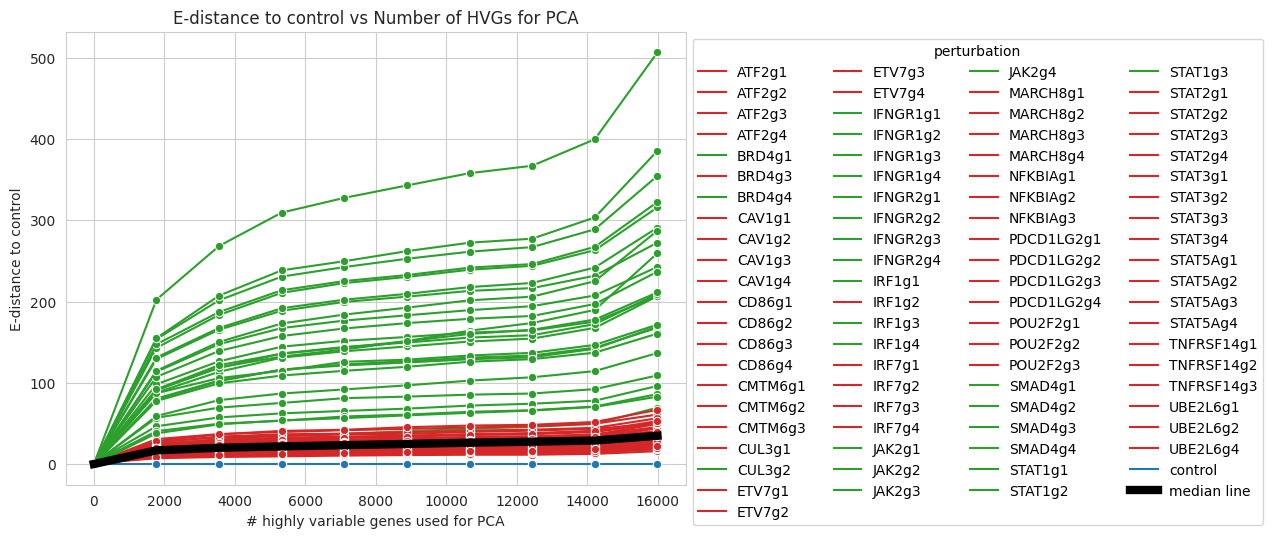

In [104]:
dataset = 'PapalexiSatija2021_eccite_RNA'
adata = sc.read(h5_files[f'tmp_data_{dataset}'])
df = test_HVGs(adata, groupby='perturbation', control='control', num=10)

100%|██████████| 10/10 [04:55<00:00, 29.57s/it]


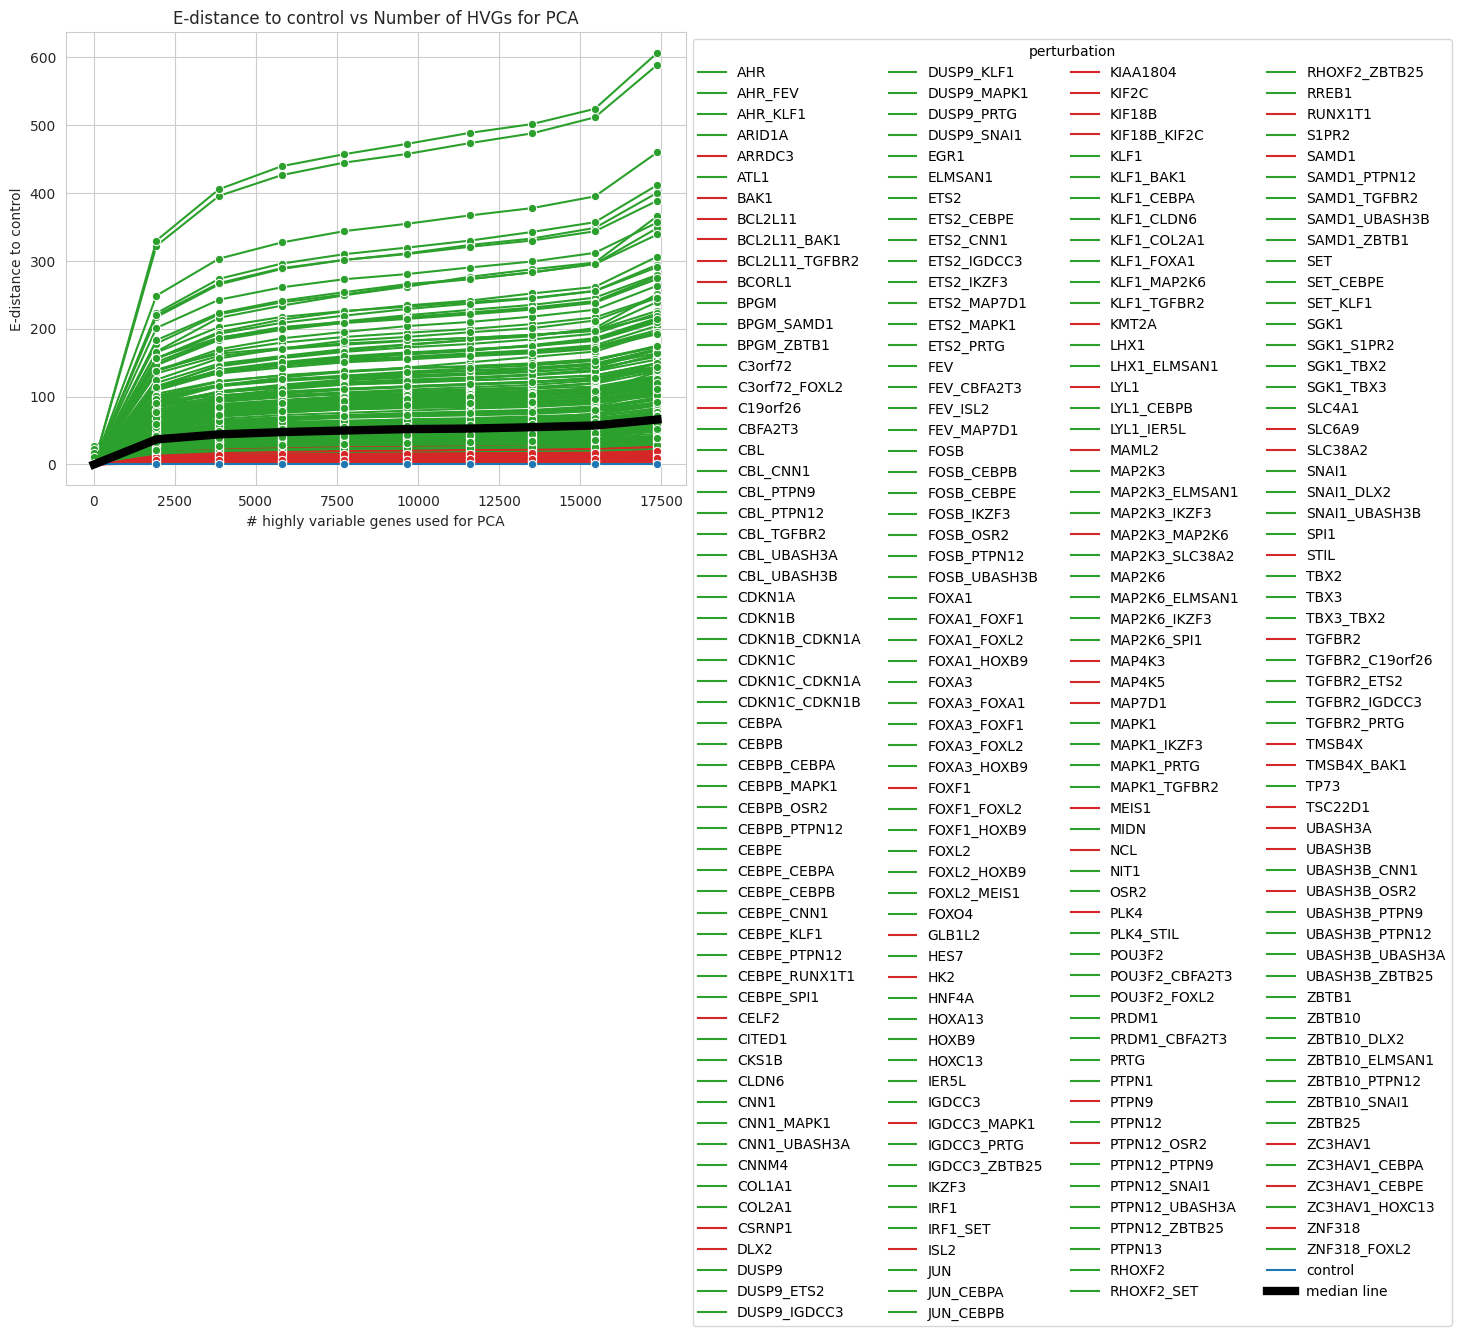

In [105]:
dataset = 'NormanWeissman2019_filtered'
adata = sc.read(h5_files[f'tmp_data_{dataset}'])
df = test_HVGs(adata, groupby='perturbation', control='control', num=10)

In [ ]:
# we do not need to know which perturbations they are.
# E-test at each step would be nice

# Dependence on number of PCs (TODO)

moved to snakemake

In [55]:
# needs to run
pd.read_csv(f'../snakemake/tables/effect_of_nHVGs_{dataset}_tables.csv')

FileNotFoundError: [Errno 2] No such file or directory: '../tables/effect_of_nHVGs_NormanWeissman2019_filtered_tables.csv'

# ncells and ncounts

In [162]:
control = 'control'
groupby = 'perturbation'

## KM like

In [169]:
def plot_KM(sdf, dataset, x, show=True, ax=None):
    # This is basically a Kaplan Meier plot
    N = len(sdf.perturbation.unique())  # number of perturbations
    with sns.axes_style('whitegrid'):
        ax = pl.subplots(figsize=(8,6), dpi=80)[-1] if ax is None else ax
    total_sig = len(sdf[(sdf.n==1) & (sdf.significant_adj=='True')])  # number of sig perts without subsampling (i.e. in original dataset)
    # record highest number of cells when significance was initially lost by a perturbation group
    timedf = sdf[sdf['significant_adj_new'] == 'False (lost)'].groupby('perturbation').max(x)
    X = [np.max(sdf[x])] + list(timedf[x].sort_values(ascending=False))
    Y = [total_sig] + list(np.arange(len(X)-1)[::-1] - len(timedf) + total_sig)  # running sum
    Y = np.array(Y) / N  # normalize to fraction of perts significant
    # ax.scatter(X[1:], np.array(Y[1:] + 1/N), marker='+', s=50, linewidths=3)
    # make piecewise constant, fixed at upper value
    # essentially this is a Kaplan Meier plot that goes from right to left.
    X_ = []
    Y_ = []
    for i in range(len(X)-1):
        X_.extend([X[i], X[i+1]])
        Y_.extend([Y[i], Y[i]])
    ax.plot(X_, Y_, label=dataset.replace('TAP_SCREEN__chromosome_11_screen', 'chr11'), linewidth=3)
    ax.yaxis.set_major_formatter(mtick.PercentFormatter(1, decimals=0))
    ax.set_xlabel('Number of cells' if x=='ncells' else 'Average number of counts per cell')
    ax.set_ylabel('Fraction of Perturbations\nwith sign. E-test')
    ax.set_title(f'Loss of significance with decreasing {x}\nin {dataset}');
    if show: 
        pl.show()
    else:
        return ax

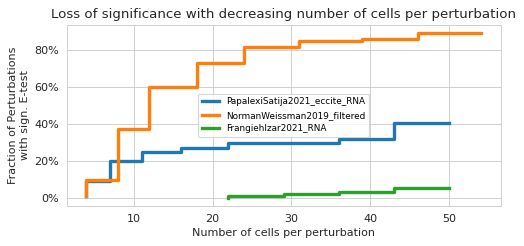

In [175]:
with sns.axes_style('whitegrid'):
    ax = pl.subplots(figsize=(7,3), dpi=80)[-1]
# sciplex3 has 3 celltypes and too many cells, also it's drugs
for dataset in ['PapalexiSatija2021_eccite_RNA', 'NormanWeissman2019_filtered', 'FrangiehIzar2021_RNA']:
    sdf = pd.read_csv(f'../snakemake/tables/effect_of_ncells_{dataset}_tables.csv', index_col=0)
    sdf = sdf[sdf.ncells>2].copy()  # not enough cells for e-test!
    ax = plot_KM(sdf, dataset, 'ncells', show=False, ax=ax)
ax.legend(fontsize=8)
ax.set_title(f'Loss of significance with decreasing number of cells per perturbation')
ax.set_xlabel('Number of cells per perturbation')
pl.savefig(f'../ncells_joint_KMplot.pdf', bbox_inches='tight')
pl.show()

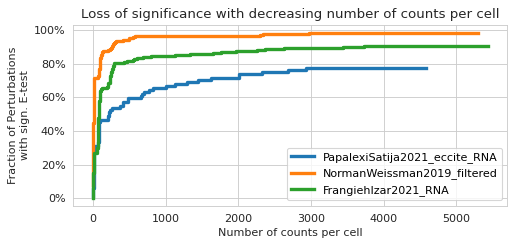

In [176]:
with sns.axes_style('whitegrid'):
    ax = pl.subplots(figsize=(7,3), dpi=80)[-1]
for dataset in ['PapalexiSatija2021_eccite_RNA', 'NormanWeissman2019_filtered', 'FrangiehIzar2021_RNA']:
    sdf = pd.read_csv(f'../snakemake/tables/effect_of_ncounts_{dataset}_tables.csv', index_col=0)
    ax = plot_KM(sdf, dataset, 'ncounts', show=False, ax=ax)
ax.legend()
ax.set_title(f'Loss of significance with decreasing number of counts per cell')
ax.set_xlabel('Number of counts per cell')
pl.savefig(f'../ncounts_joint_KMplot.pdf', bbox_inches='tight')
pl.show()

## scatter/strip

In [80]:
cdict = {
    'True (gained)': 'tab:green',
    'True': 'green',
    'False': 'tab:blue',
    'False (lost)': 'tab:red',
    'control': 'black'
}

In [122]:
def plot_strip(sdf, dataset, xkey='ncells', x='n', save=True, show=True, ax=None):
    # strip plot
    from matplotlib.ticker import StrMethodFormatter
    with sns.axes_style('whitegrid'):
            ax = pl.subplots(figsize=(8,6), dpi=80)[-1] if ax is None else ax
    ax.set_yscale('log')
    sns.stripplot(data=sdf, x=x, y='edist', hue='significant_adj_new', palette=cdict)
    ax.set_ylabel(f'E-distance to {control}')
    ax.set_xlabel(xkey)
    ax.set_title(f'E-distances in {dataset}')
    med_df=sdf.groupby('n').median()
    ax.plot(np.arange(len(med_df)), med_df.edist, label='median line', linewidth=5, color='black')
    ax.legend(title='E-test significant\n(p-value < 0.05)')
    ax.set_xticklabels(np.round(sdf.n.unique(), 3))
    if save: pl.savefig(f'../{dataset}_{xkey}_stripplot.pdf', bbox_inches='tight')
    if show: pl.show()

def plot_scatter(sdf, dataset, x, save=True, show=True, ax=None):
    # Continuous scale + KM plot
    with sns.axes_style('whitegrid'):
        ax = pl.subplots(figsize=(8,6), dpi=80)[-1] if ax is None else ax
    ax.set_yscale('log')
    #ax.set_xscale('log')
    sns.scatterplot(data=sdf, x=x, y='edist', hue='significant_adj_new', palette=cdict)
    ax.set_ylabel(f'E-distance to {control}')
    ax.set_xlabel(x)
    ax.set_title(f'Loss of E-test significances with decreasing {x}\nin {dataset}')
    #ax.plot(med_df.index, med_df.edist, label='median line', linewidth=6, color='black')
    ax.legend(title='E-test significant\n(p-value < 0.05)')
    if save: pl.savefig(f'../{dataset}_{x}.pdf', bbox_inches='tight')
    if show: pl.show()

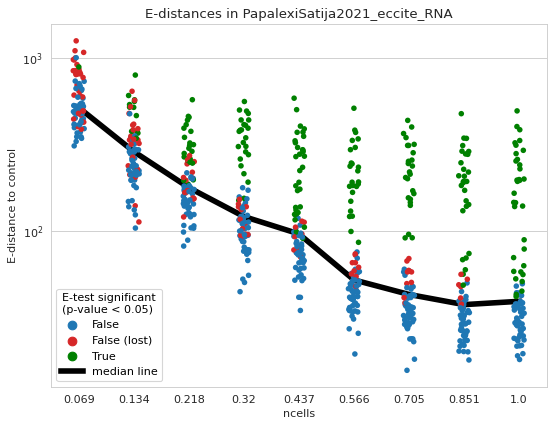

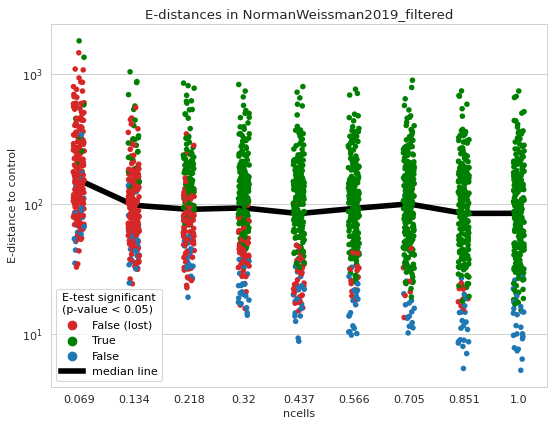

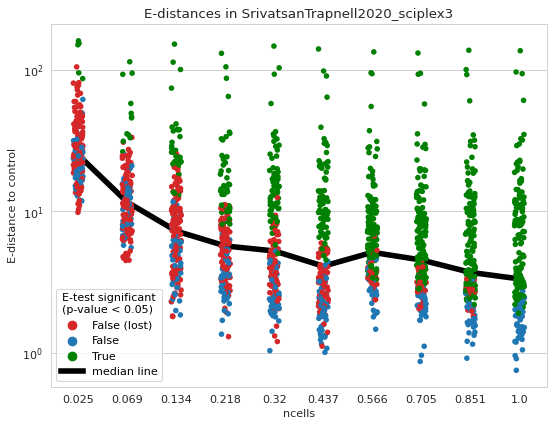

FileNotFoundError: [Errno 2] No such file or directory: '../snakemake/tables/effect_of_ncells_FrangiehIzar2021_RNA_tables.csv'

In [123]:
for dataset in datasets:
    sdf = pd.read_csv(f'../snakemake/tables/effect_of_ncells_{dataset}_tables.csv', index_col=0)
    sdf = sdf[sdf.ncells>2].copy()  # not enough cells for e-test!
    sdf['significant_adj_new'][sdf.significant_adj_new=='True (gained)'] = 'True'  # we don't care about gains (unlike body builders)
    sdf = sdf[sdf.perturbation != control]
    
    plot_strip(sdf, dataset, 'ncells')
    # plot_scatter(sdf, dataset, 'ncells')
    

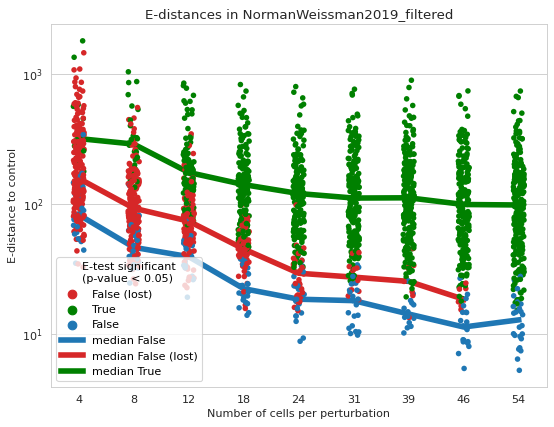

In [157]:
dataset = 'NormanWeissman2019_filtered'
sdf = pd.read_csv(f'../snakemake/tables/effect_of_ncells_{dataset}_tables.csv', index_col=0)
sdf = sdf[sdf.ncells>2].copy()  # not enough cells for e-test!
sdf['significant_adj_new'][sdf.significant_adj_new=='True (gained)'] = 'True'  # we don't care about gains (unlike body builders)
sdf = sdf[sdf.perturbation != control]

# strip plot
from matplotlib.ticker import StrMethodFormatter
with sns.axes_style('whitegrid'):
    ax = pl.subplots(figsize=(8,6), dpi=80)[-1]
ax.set_yscale('log')
sns.stripplot(data=sdf, x='ncells', y='edist', hue='significant_adj_new', palette=cdict)
ax.set_ylabel(f'E-distance to {control}')
ax.set_xlabel('Number of cells per perturbation')
ax.set_title(f'E-distances in {dataset}')

#med_df=sdf.groupby('n').median()
#ax.plot(np.arange(len(med_df)), med_df.edist, label='median line', linewidth=5, color='black')

med_df = sdf.groupby(['significant_adj_new', 'n']).median()
for idx in med_df.index.get_level_values(0).unique():
    ax.plot(np.arange(len(med_df.loc[idx])), med_df.loc[idx].edist, label=f'median {idx}', linewidth=5, color=cdict[idx])

ax.legend(title='E-test significant\n(p-value < 0.05)')
pl.savefig(f'../{dataset}_ncells_stripplot.pdf', bbox_inches='tight')
pl.show()

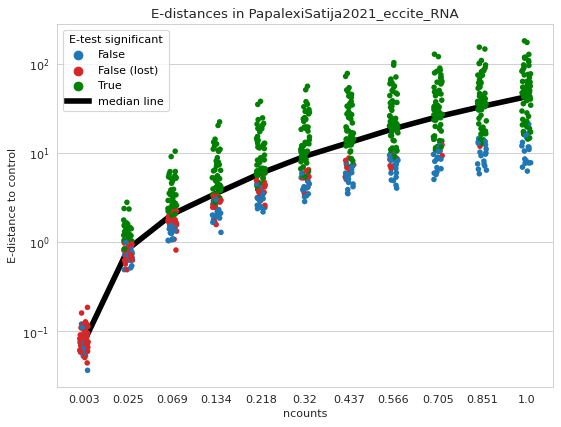

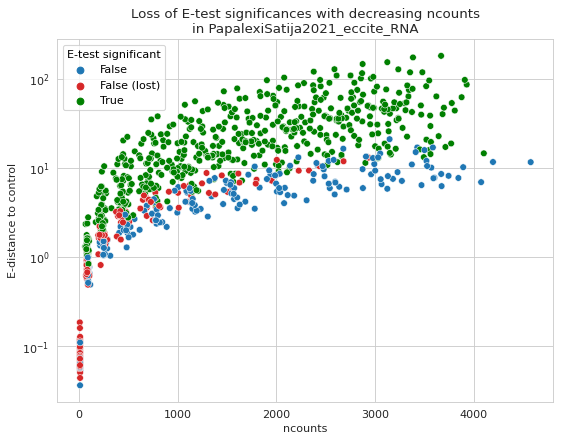

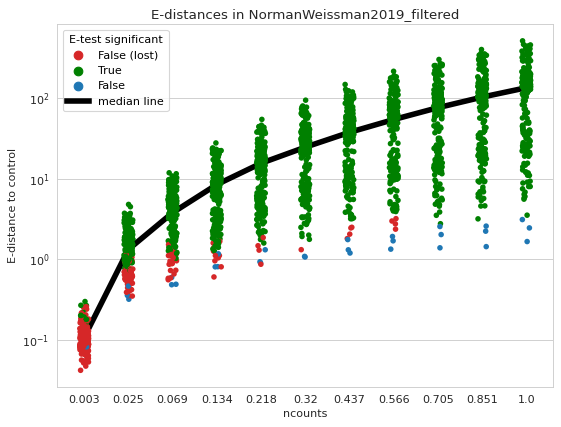

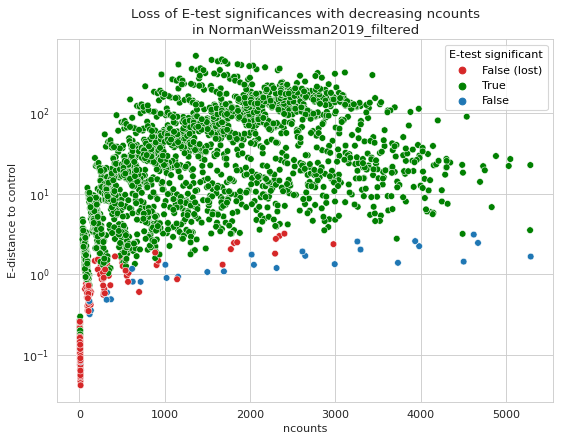

FileNotFoundError: [Errno 2] No such file or directory: '../snakemake/tables/effect_of_ncounts_SrivatsanTrapnell2020_sciplex3_tables.csv'

In [99]:
for dataset in datasets:
    sdf = pd.read_csv(f'../snakemake/tables/effect_of_ncounts_{dataset}_tables.csv', index_col=0)
    sdf['significant_adj_new'][sdf.significant_adj_new=='True (gained)'] = 'True'  # we don't care about gains (unlike body builders)
    sdf = sdf[sdf.perturbation != control]
    
    plot_strip(sdf, dataset, 'ncounts')
    plot_scatter(sdf, dataset, 'ncounts')
    

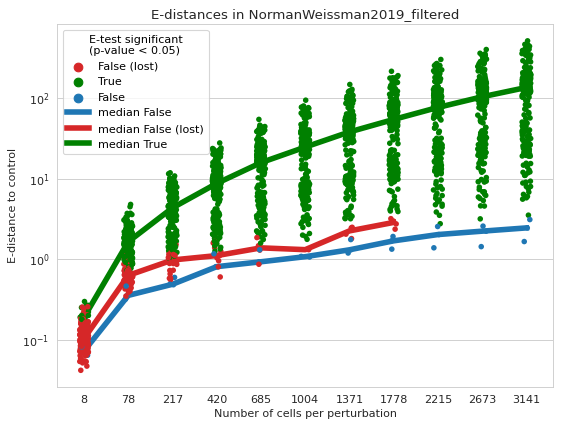

In [156]:
dataset = 'NormanWeissman2019_filtered'
sdf = pd.read_csv(f'../snakemake/tables/effect_of_ncounts_{dataset}_tables.csv', index_col=0)
sdf['significant_adj_new'][sdf.significant_adj_new=='True (gained)'] = 'True'  # we don't care about gains (unlike body builders)
sdf = sdf[sdf.perturbation != control]

# strip plot
from matplotlib.ticker import StrMethodFormatter
with sns.axes_style('whitegrid'):
    ax = pl.subplots(figsize=(8,6), dpi=80)[-1]
ax.set_yscale('log')
sns.stripplot(data=sdf, x='n', y='edist', hue='significant_adj_new', palette=cdict)
ax.set_ylabel(f'E-distance to {control}')
ax.set_xlabel('Number of cells per perturbation')
ax.set_title(f'E-distances in {dataset}')

#med_df=sdf.groupby('n').median()
#ax.plot(np.arange(len(med_df)), med_df.edist, label='median line', linewidth=5, color='black')

med_df = sdf.groupby(['significant_adj_new', 'n']).median()
for idx in med_df.index.get_level_values(0).unique():
    ax.plot(np.arange(len(med_df.loc[idx])), med_df.loc[idx].edist, label=f'median {idx}', linewidth=5, color=cdict[idx])

ax.legend(title='E-test significant\n(p-value < 0.05)')
#ax.set_xticklabels(np.round(sdf.n.unique(), 3))
ax.set_xticklabels(np.array(sdf.groupby('n').mean()['ncounts'], dtype=int))

pl.savefig(f'../{dataset}_ncounts_stripplot.pdf', bbox_inches='tight')
pl.show()

# Dependence on ncells (outdated)

In [71]:
dataset='NormanWeissman2019_filtered'
sdf = pd.read_csv(f'../snakemake/tables/effect_of_ncells_{dataset}_tables.csv', index_col=0)
sdf.head()

n perturbation        edist  pvalue  significant  pvalue_adj  \
0  0.002796          AHR   440.361878     0.0         True         0.0   
1  0.002796      AHR_FEV  1138.061432     0.0         True         0.0   
2  0.002796     AHR_KLF1  4318.536547     0.0         True         0.0   
3  0.002796       ARID1A   525.406654     0.0         True         0.0   
4  0.002796       ARRDC3  1571.329108     0.0         True         0.0   

  significant_adj        delta  sigma  ncells significant_adj_new  
0            True   220.180939    0.0       1                True  
1            True   569.030716    0.0       1                True  
2            True  2159.268273    0.0       1                True  
3            True   262.703327    0.0       1                True  
4            True   785.664554    0.0       1                True

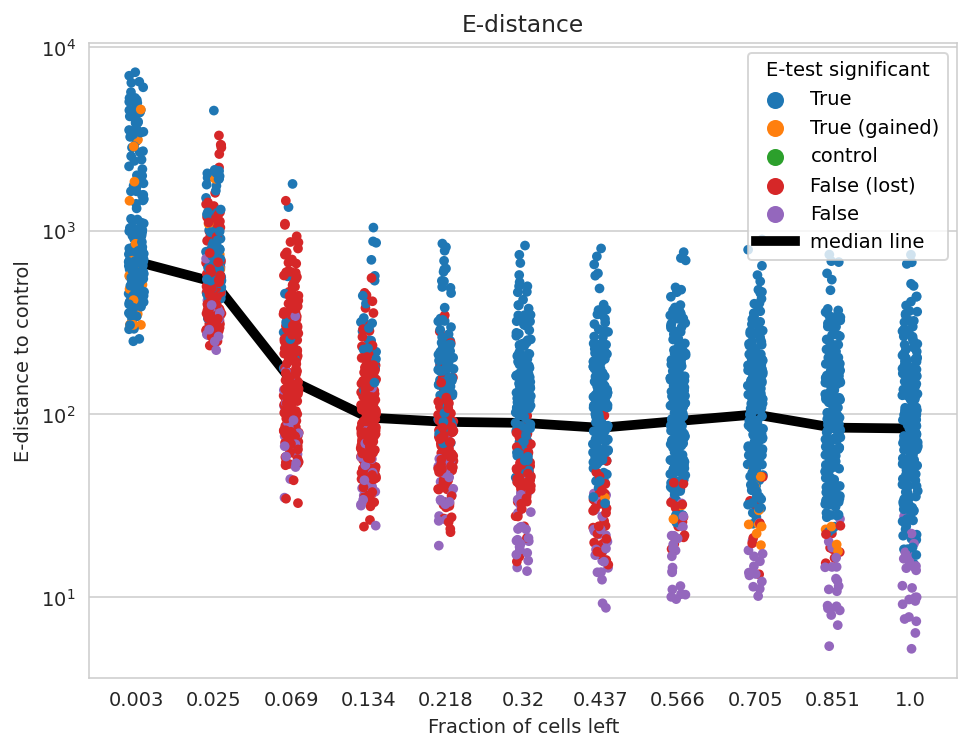

In [72]:
from matplotlib.ticker import StrMethodFormatter
with sns.axes_style('whitegrid'):
    fig, ax = pl.subplots(figsize=(8,6), dpi=140)
ax.set_yscale('log')
sns.stripplot(data=sdf, x='n', y='edist', hue='significant_adj_new')
ax.set_ylabel(f'E-distance to {control}')
ax.set_xlabel('Fraction of cells left')
ax.set_title('E-distance')
med_df=sdf.groupby('n').median()
ax.plot(np.arange(len(med_df)), med_df.edist, label='median line', linewidth=5, color='black')
ax.legend(title='E-test significant')
ax.set_xticklabels(np.round(sdf.n.unique(), 3))
# pl.savefig(f'../{dataset}_ncells_stripplot.pdf', bbox_inches='tight')
pl.show()

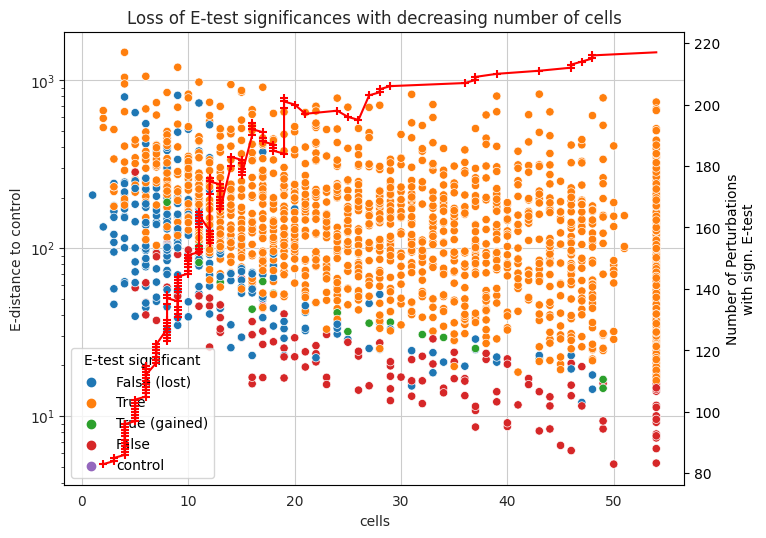

In [240]:
add_survival = True

with sns.axes_style('whitegrid'):
    fig, ax = pl.subplots(figsize=(8,6), dpi=100)
ax.set_yscale('log')
#ax.set_xscale('log')
sns.scatterplot(data=sdf, x='ncells', y='edist', hue='significant_adj_new')
ax.set_ylabel(f'E-distance to {control}')
ax.set_xlabel('cells')
ax.set_title('Loss of E-test significances with decreasing number of cells')

#ax.plot(med_df.index, med_df.edist, label='median line', linewidth=6, color='black')
ax.legend(title='E-test significant')

if add_survival:
    ax2 = ax.twinx()
    # This is basically a Kaplan Meier plot
    total_sig = len(sdf[(sdf.n==1) & (sdf.significant_adj=='True')])  # number of sig perts without subsampling
    # record highest number of counts when significance was initially lost by a perturbation group
    timedf = sdf[sdf['significant_adj_new'] == 'False (lost)'].groupby('perturbation').max('ncells')
    x = [np.max(sdf.ncells)] + list(timedf.ncells.sort_values(ascending=False))
    y = [total_sig] + list(np.arange(len(x)-1)[::-1] - len(timedf) + total_sig)  # running sum
    ax2.plot(x, y, c='r')
    ax2.scatter(x[1:], y[1:], marker='+', c='r')
    ax2.set_ylabel('Number of Perturbations\nwith sign. E-test')
pl.savefig(f'../{dataset}_ncells_with_KMplot.pdf', bbox_inches='tight')
pl.show()

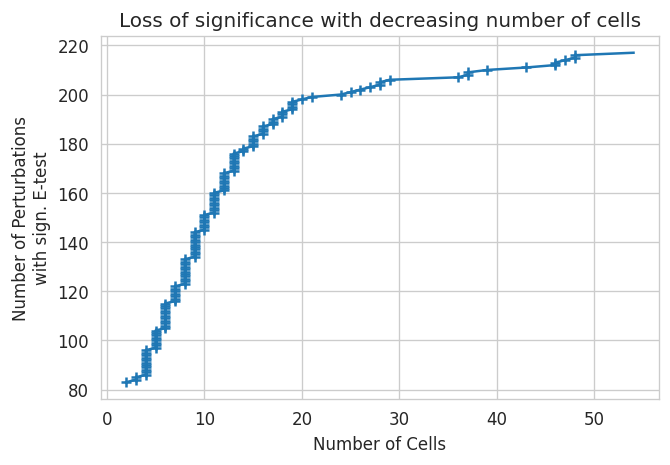

In [255]:
# This is basically a Kaplan Meier plot
with sns.axes_style('whitegrid'):
    fig, ax = pl.subplots(figsize=(6,4), dpi=120)

total_sig = len(sdf[(sdf.n==1) & (sdf.significant_adj=='True')])  # number of sig perts without subsampling

# record highest number of cells when significance was initially lost by a perturbation group
timedf = sdf[sdf['significant_adj_new'] == 'False (lost)'].groupby('perturbation').max('ncells')

x = [np.max(sdf.ncells)] + list(timedf.ncells.sort_values(ascending=False))  # sorted by ncells
y = [total_sig] + list(np.arange(len(x)-1)[::-1] - len(timedf) + total_sig)  # running sum

ax.plot(x, y)
ax.scatter(x[1:], y[1:], marker='+')
ax.set_xlabel('Number of Cells')
ax.set_ylabel('Number of Perturbations\nwith sign. E-test')
ax.set_title('Loss of significance with decreasing number of cells')
pl.savefig(f'../{dataset}_ncells_KMplot.pdf', bbox_inches='tight')
pl.show()

# Dependence on counts (outdated)

In [450]:
sdf = pd.read_csv(f'../snakemake/tables/effect_of_ncounts_{dataset}_tables.csv', index_col=0)
sdf.head()

n perturbation     edist  pvalue  significant  pvalue_adj  \
0  0.002796          AHR  0.091462    0.48        False         1.0   
1  0.002796      AHR_FEV  0.265318    0.00         True         0.0   
2  0.002796     AHR_KLF1  0.077439    0.40        False         1.0   
3  0.002796       ARID1A  0.189691    0.00         True         0.0   
4  0.002796       ARRDC3  0.091929    0.36        False         1.0   

  significant_adj     delta     sigma    ncounts significant_adj_new  
0           False  2.467168  3.232090   7.166666        False (lost)  
1            True  2.830180  3.784258   5.074074                True  
2           False  2.055199  2.422174  11.129630        False (lost)  
3            True  2.931393  4.062310   7.555555                True  
4           False  2.272422  2.842131  10.259259        False (lost)

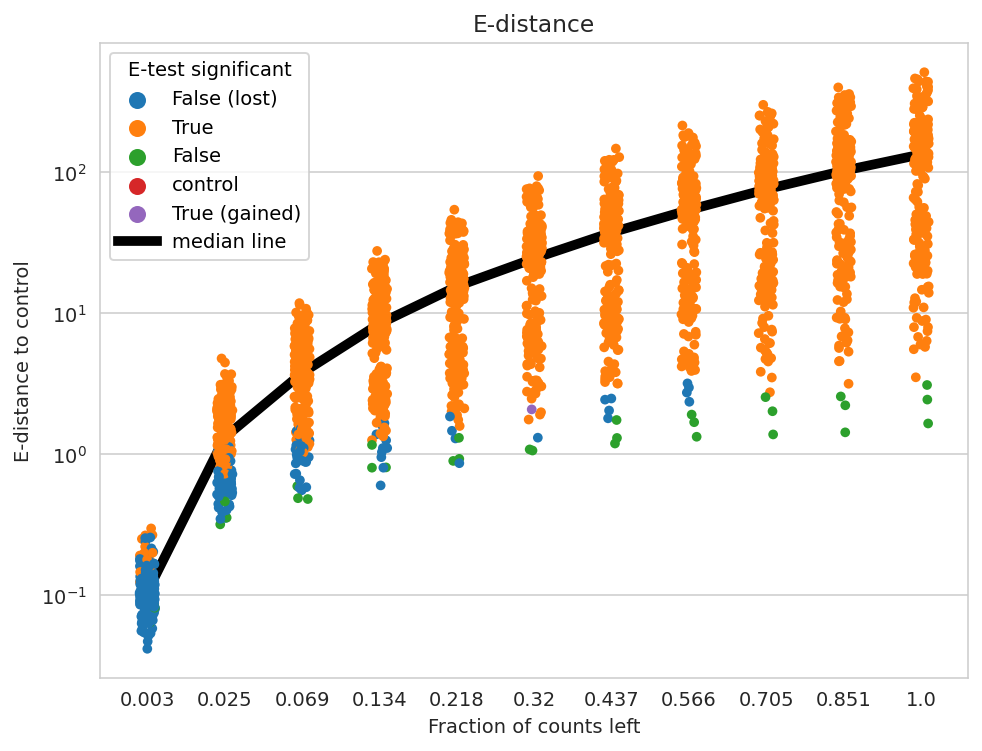

In [451]:
from matplotlib.ticker import StrMethodFormatter

with sns.axes_style('whitegrid'):
    fig, ax = pl.subplots(figsize=(8,6), dpi=140)
ax.set_yscale('log')
sns.stripplot(data=sdf, x='n', y='edist', hue='significant_adj_new')
ax.set_ylabel(f'E-distance to {control}')
ax.set_xlabel('Fraction of counts left')
ax.set_title('E-distance')
med_df=sdf.groupby('n').median()
ax.plot(np.arange(len(med_df)), med_df.edist, label='median line', linewidth=5, color='black')
ax.legend(title='E-test significant')
ax.set_xticklabels(np.round(sdf.n.unique(), 3))
pl.savefig(f'../{dataset}_ncounts_stripplot.pdf', bbox_inches='tight')
pl.show()

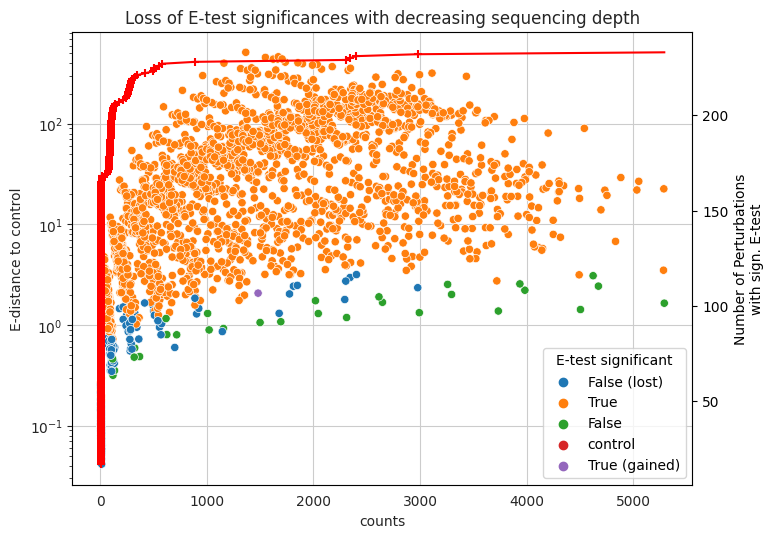

In [452]:
add_survival = True

with sns.axes_style('whitegrid'):
    fig, ax = pl.subplots(figsize=(8,6), dpi=100)
ax.set_yscale('log')
#ax.set_xscale('log')
sns.scatterplot(data=sdf, x='ncounts', y='edist', hue='significant_adj_new')
ax.set_ylabel(f'E-distance to {control}')
ax.set_xlabel('counts')
ax.set_title('Loss of E-test significances with decreasing sequencing depth')

#ax.plot(med_df.index, med_df.edist, label='median line', linewidth=6, color='black')
ax.legend(title='E-test significant')

if add_survival:
    ax2 = ax.twinx()
    # This is basically a Kaplan Meier plot
    total_sig = len(sdf[(sdf.n==1) & (sdf.significant_adj=='True')])  # number of sig perts without subsampling
    # record highest number of counts when significance was initially lost by a perturbation group
    timedf = sdf[sdf['significant_adj_new'] == 'False (lost)'].groupby('perturbation').max('ncounts')
    x = [np.max(sdf.ncounts)] + list(timedf.ncounts.sort_values(ascending=False))
    y = [total_sig] + list(np.arange(len(x)-1)[::-1] - len(timedf) + total_sig)  # running sum
    ax2.plot(x, y, c='r')
    ax2.scatter(x[1:], y[1:], marker='+', c='r')
    ax2.set_ylabel('Number of Perturbations\nwith sign. E-test')
pl.savefig(f'../{dataset}_ncounts_with_KMplot.pdf', bbox_inches='tight')
pl.show()

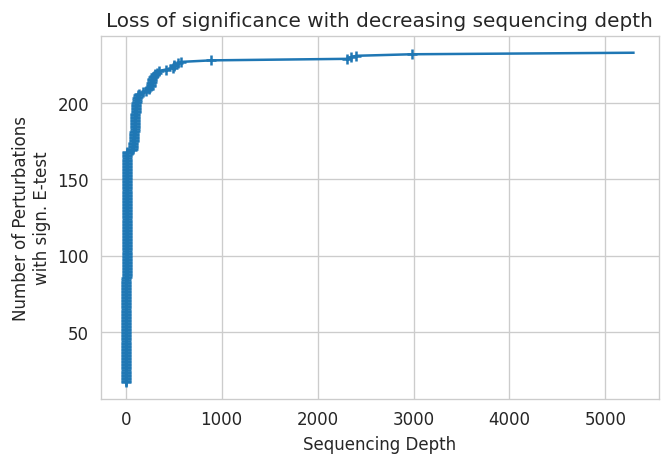

In [453]:
# This is basically a Kaplan Meier plot
with sns.axes_style('whitegrid'):
    fig, ax = pl.subplots(figsize=(6,4), dpi=120)

total_sig = len(sdf[(sdf.n==1) & (sdf.significant_adj=='True')])  # number of sig perts without subsampling

# record highest number of counts when significance was initially lost by a perturbation group
timedf = sdf[sdf['significant_adj_new'] == 'False (lost)'].groupby('perturbation').max('ncounts')

x = [np.max(sdf.ncounts)] + list(timedf.ncounts.sort_values(ascending=False))
y = [total_sig] + list(np.arange(len(x)-1)[::-1] - len(timedf) + total_sig)  # running sum
ax.plot(x, y)
ax.scatter(x[1:], y[1:], marker='+')
ax.set_xlabel('Sequencing Depth')
ax.set_ylabel('Number of Perturbations\nwith sign. E-test')
ax.set_title('Loss of significance with decreasing sequencing depth')
pl.savefig(f'../{dataset}_ncounts_KMplot.pdf', bbox_inches='tight')
pl.show()

# Joint (ncells, ncounts) subsampling (deprecated, results not convincing, high effort)

In [20]:
# this will be a complicated tensor I guess
# %ncounts x %ncells x perturbation x significance/distance
# I will lose the tensor structure when moving from % to absolutes
# Then could catch number of insig perturbations and make it a scatter with ncells and ncounts the x and y coords, then color background

In [73]:
dataset = 'PapalexiSatija2021_eccite_RNA'
# dataset = 'NormanWeissman2019_filtered'
# dataset = 'SrivatsanTrapnell2020_sciplex3'

control = 'control'
groupby = 'perturbation'

In [74]:
sdf = pd.read_csv(f'../snakemake/tables/save_effect_of_both_{dataset}_tables.csv', index_col=0)

sdf['significant_adj_new'] = sdf['significant_adj']
for g in sdf.perturbation.unique():
    if sdf['significant_adj'][(sdf[groupby]==g) & (sdf['n']=='1.0_1.0')].iloc[0]==True:
        sdf['significant_adj_new'][(sdf[groupby]==g) & (sdf['significant_adj']==False)] = 'False (lost)'
    elif sdf['significant_adj'][(sdf[groupby]==g) & (sdf['n']=='1.0_1.0')].iloc[0]==False:
        sdf['significant_adj_new'][(sdf.perturbation==g) & (sdf['significant_adj']==True)] = 'True (gained)'
        
sdf[['n_cells', 'n_counts']] = np.array([x.split('_') for x in sdf.n], dtype='float')
sdf.head()

n perturbation      edist  pvalue  \
0  0.010178558119067316_0.010178558119067316       ATF2g1  42.070234     0.0   
1  0.010178558119067316_0.010178558119067316       ATF2g2  52.678040     0.0   
2  0.010178558119067316_0.010178558119067316       ATF2g3  55.735894     0.0   
3  0.010178558119067316_0.010178558119067316       ATF2g4  53.237979     0.0   
4  0.010178558119067316_0.010178558119067316       BRD4g1  47.112235     0.0   

   significant  pvalue_adj significant_adj      delta  sigma  ncounts  ncells  \
0         True         0.0            True  21.035117    0.0     73.0       1   
1         True         0.0            True  26.339020    0.0     36.0       1   
2         True         0.0            True  27.867947    0.0     34.0       1   
3         True         0.0            True  26.618989    0.0     42.0       1   
4         True         0.0            True  23.556118    0.0     40.0       1   

  significant_adj_new   n_cells  n_counts  
0                True  0.010179  0.010179  
1                True  0.010179  0.010179  
2                True  0.010179  0.010179  
3                True  0.010179  0.010179  
4                True  0.010179  0.010179

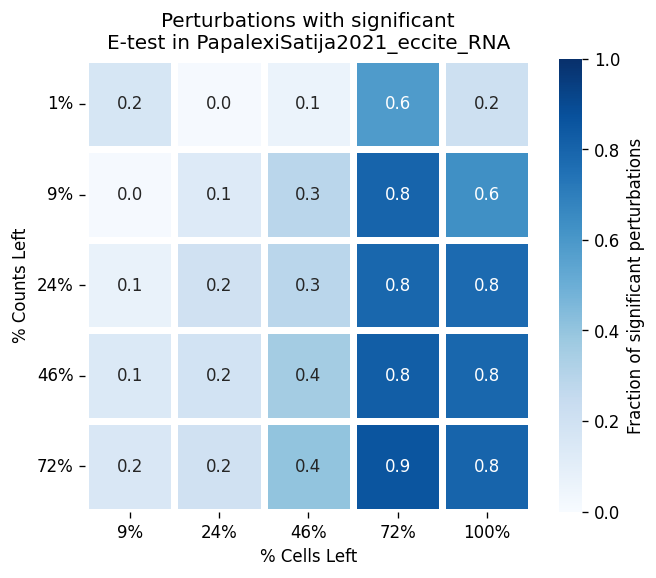

In [75]:
A = pd.DataFrame(0, index=sdf.n_counts.unique(), columns=sdf.n_cells.unique())
for nco in sdf.n_counts.unique():
    for nce in sdf.n_cells.unique():
        cts = sdf[(sdf.n_counts==nco) & (sdf.n_cells==nce)].significant_adj.value_counts()
        A.loc[nco, nce] = cts['True'] / np.sum(cts) if 'True' in cts.index else 0  # percent significant
A.index = [str(int(np.round(k,2)*100))+'%' for k in A.index]
A.columns = [str(int(np.round(k,2)*100))+'%' for k in A.columns]

fig, ax = pl.subplots(figsize=(6,5), dpi=120)
B = A.iloc[:-1,1:]  # papalexi
sns.heatmap(B, vmin=0, vmax=1, cmap='Blues', linewidths=4, annot=True, fmt='.1f',
            cbar_kws={'label': 'Fraction of significant perturbations'});
pl.title(f'Perturbations with significant\nE-test in {dataset}');
pl.ylabel('% Counts Left')
pl.xlabel('% Cells Left')
pl.yticks(rotation=0)
pl.show()

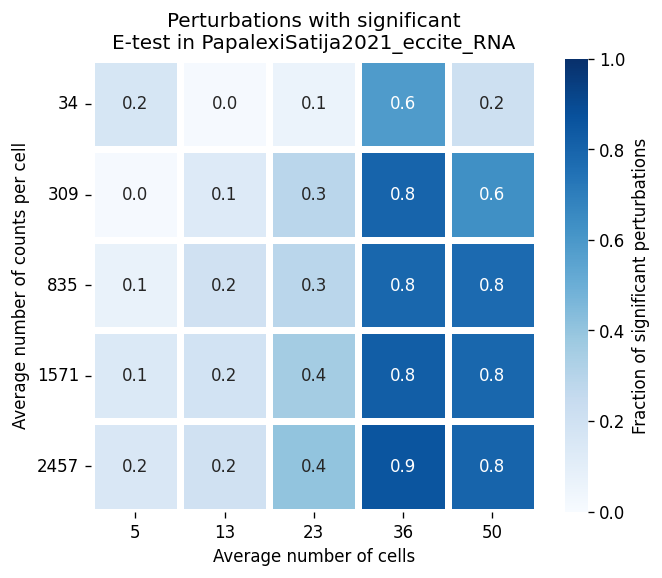

In [76]:
A = pd.DataFrame(0, index=sdf.n_counts.unique(), columns=sdf.n_cells.unique())
for nco in sdf.n_counts.unique():
    for nce in sdf.n_cells.unique():
        cts = sdf[(sdf.n_counts==nco) & (sdf.n_cells==nce)].significant_adj.value_counts()
        A.loc[nco, nce] = cts['True'] / np.sum(cts) if 'True' in cts.index else 0  # percent significant
# A.index = [str(int(np.round(k,2)*100))+'%' for k in A.index]
# A.columns = [str(int(np.round(k,2)*100))+'%' for k in A.columns]
A.index = sdf.groupby(['n_counts']).mean().ncounts.astype(int)
A.columns = sdf.groupby(['n_cells']).mean().ncells.astype(int)

fig, ax = pl.subplots(figsize=(6,5), dpi=120)
B = A.iloc[:-1,1:]  # papalexi
sns.heatmap(B, vmin=0, vmax=1, cmap='Blues', linewidths=4, annot=True, fmt='.1f',
            cbar_kws={'label': 'Fraction of significant perturbations'});
pl.title(f'Perturbations with significant\nE-test in {dataset}');
pl.ylabel('Average number of counts per cell')
pl.xlabel('Average number of cells')
pl.yticks(rotation=0)
pl.show()

In [56]:
sdf.groupby(['n_cells', 'n_counts']).mean().reset_index().pivot('n_cells', 'n_counts', 'edist')

n_counts  0.004266  0.038174   0.104837   0.201983   0.326304   0.473568  \
n_cells                                                                    
0.004266  0.881008  5.761057  15.555062  28.720914  40.014541  57.517290   
0.038174  0.079738  0.363467   1.213720   2.043115   3.312960   4.656468   
0.104837  0.038223  0.211547   0.692363   1.277916   2.104663   3.197538   
0.201983  0.050841  0.480159   0.913352   1.784160   3.180761   4.707417   
0.326304  0.130108  1.048000   2.337169   3.509903   5.500080   8.416220   
0.473568  0.096239  0.690277   1.613878   2.764028   4.473668   6.696484   
0.638758  0.106109  0.533988   1.233419   2.224544   3.434343   5.104725   
0.816250  0.236424  1.111695   2.073870   3.668196   6.150858   9.732821   
1.000000  0.196721  0.885409   1.864508   3.109166   5.278070   8.298979   

n_counts   0.638758   0.816250  1.000000  
n_cells                                   
0.004266  74.405966  93.665119  8.333141  
0.038174   5.942866   7.623166  8.333141  
0.104837   4.553312   6.329181  8.333141  
0.201983   6.776111   9.371071  8.333141  
0.326304  12.233537  17.051004  8.333141  
0.473568   9.614877  13.417280  8.333141  
0.638758   7.352593  10.069357  8.333141  
0.816250  14.389007  19.885761  8.333141  
1.000000  12.185359  16.752506  8.333141

In [57]:
sdf.groupby(['n_cells', 'n_counts']).mean().reset_index().pivot('n_cells', 'n_counts', 'significant')

n_counts  0.004266  0.038174  0.104837  0.201983  0.326304  0.473568  \
n_cells                                                                
0.004266  0.687831  0.216931  0.269841  0.677249  0.264550  0.291005   
0.038174  0.010582  0.031746  0.158730  0.153439  0.169312  0.142857   
0.104837  0.037037  0.201058  0.544974  0.582011  0.592593  0.603175   
0.201983  0.375661  0.624339  0.693122  0.714286  0.740741  0.708995   
0.326304  0.777778  0.894180  0.910053  0.941799  0.941799  0.947090   
0.473568  0.597884  0.708995  0.788360  0.798942  0.804233  0.788360   
0.638758  0.460317  0.910053  0.830688  0.846561  0.857143  0.830688   
0.816250  0.899471  0.978836  0.984127  0.984127  0.989418  0.984127   
1.000000  0.788360  0.915344  0.941799  0.931217  0.936508  0.931217   

n_counts  0.638758  0.816250  1.000000  
n_cells                                 
0.004266  0.238095  0.227513  0.931217  
0.038174  0.095238  0.105820  0.931217  
0.104837  0.592593  0.597884  0.931217  
0.201983  0.714286  0.719577  0.931217  
0.326304  0.952381  0.952381  0.931217  
0.473568  0.788360  0.788360  0.931217  
0.638758  0.809524  0.798942  0.931217  
0.816250  0.984127  0.984127  0.931217  
1.000000  0.931217  0.925926  0.931217

# Complete multipanel (outdated)

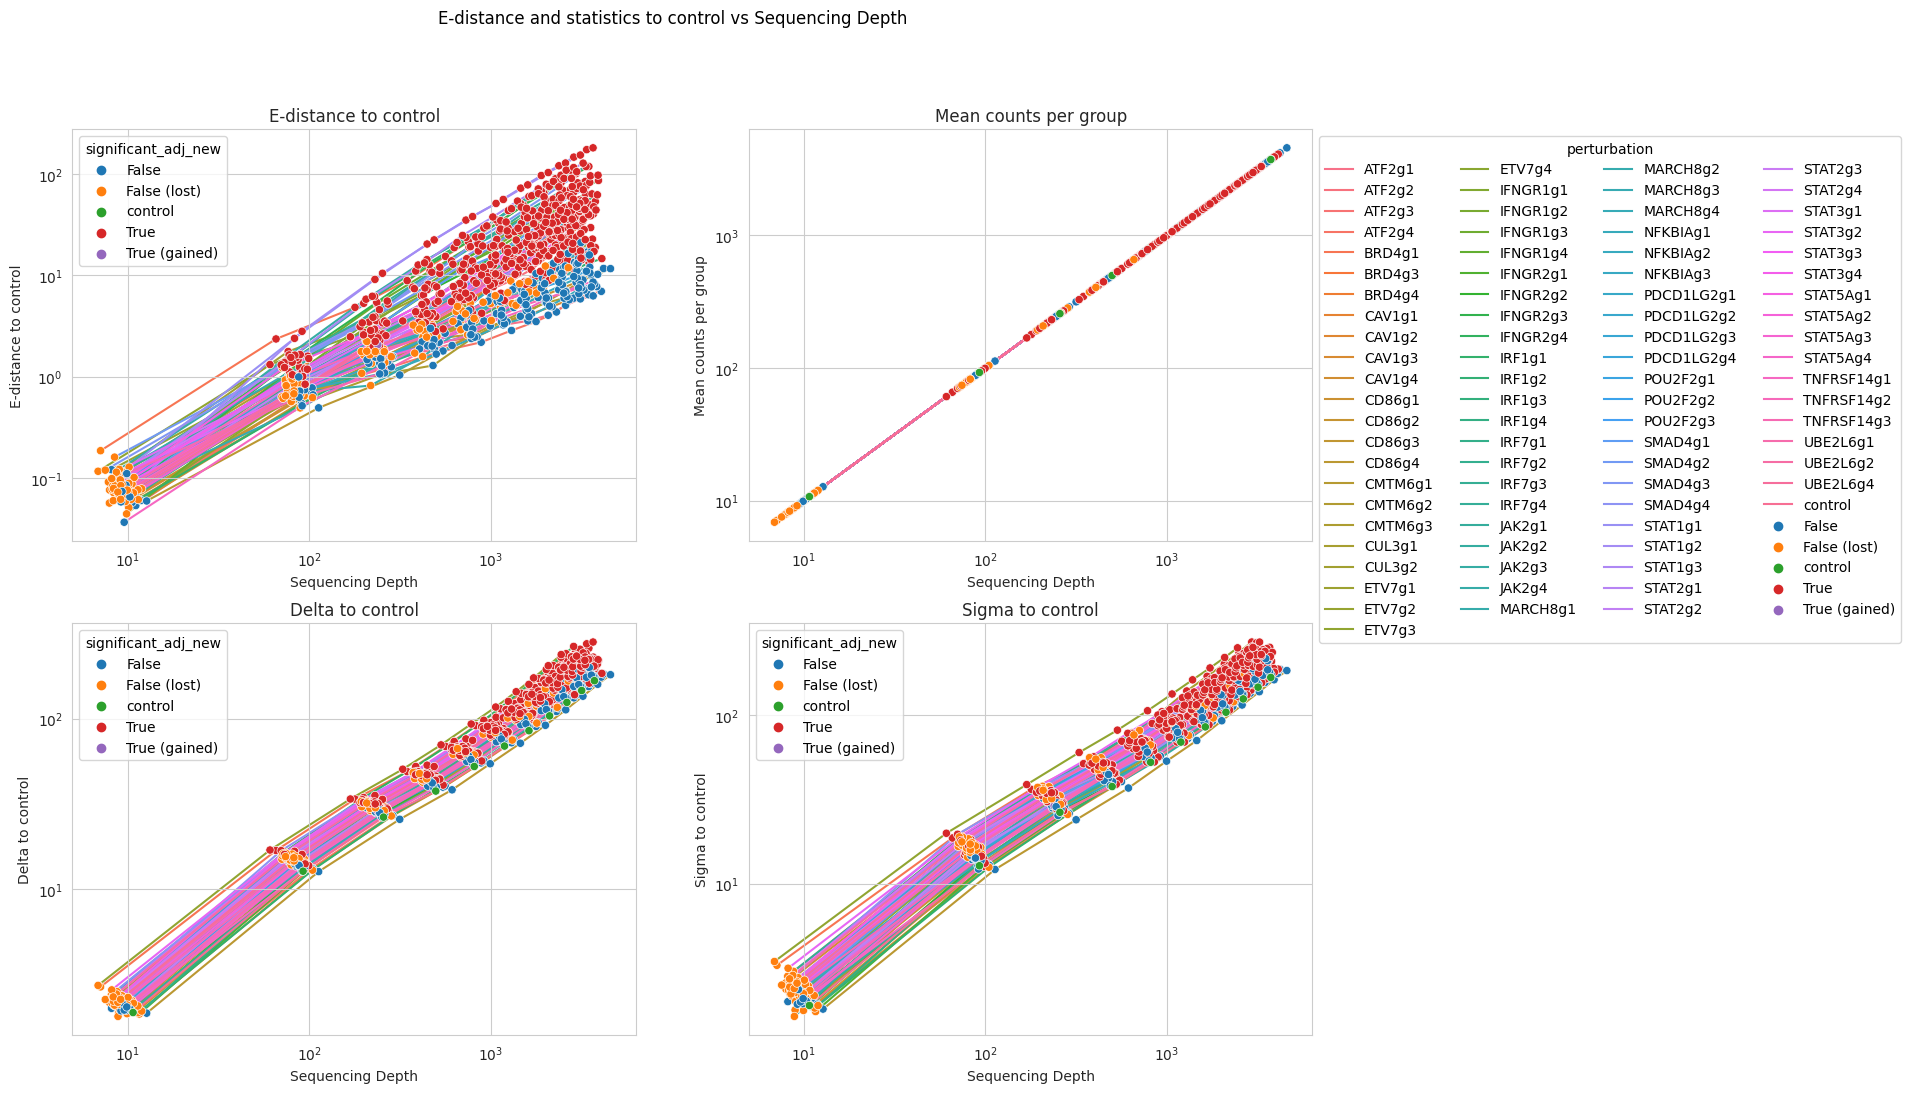

In [216]:
x = 'ncounts'
xlabel = 'Sequencing Depth'

with sns.axes_style('whitegrid'):
    fig, axs = pl.subplots(2, 2, figsize=(8*2,6*2), dpi=100)
lineplot_kwargs = dict(hue=groupby, color='grey', x=x, zorder=-1)
scatterplot_kwargs = dict(hue='significant_adj_new', marker="o", x=x)

for y, ax, title in zip(['edist', 'ncounts', 'delta', 'sigma'],
                        np.ravel(axs),
                        [f'E-distance to {control}', 'Mean counts per group', f'Delta to {control}', f'Sigma to {control}']
                       ):
    plot=sns.lineplot(data=sdf, ax=ax, y=y, legend=ax==axs[0,-1], **lineplot_kwargs)
    sns.scatterplot(data=sdf, ax=ax, y=y, **scatterplot_kwargs)
    ax.set_ylabel(title)
    ax.set_title(title)
    ax.set_xscale('log')
    ax.set_yscale('log')
    ax.set_xlabel(xlabel)
    
    # merge tight legend
    if y=='ncounts':
        h,l = plot.axes.get_legend_handles_labels()
        plot.axes.legend_.remove()
        ax.legend(h,l, ncol=4, bbox_to_anchor=(1,1), title=groupby)

pl.suptitle(f'E-distance and statistics to {control} vs {xlabel}')
pl.savefig(f'../{dataset}_ncounts_complete_loglog.pdf', bbox_inches='tight')
pl.show()

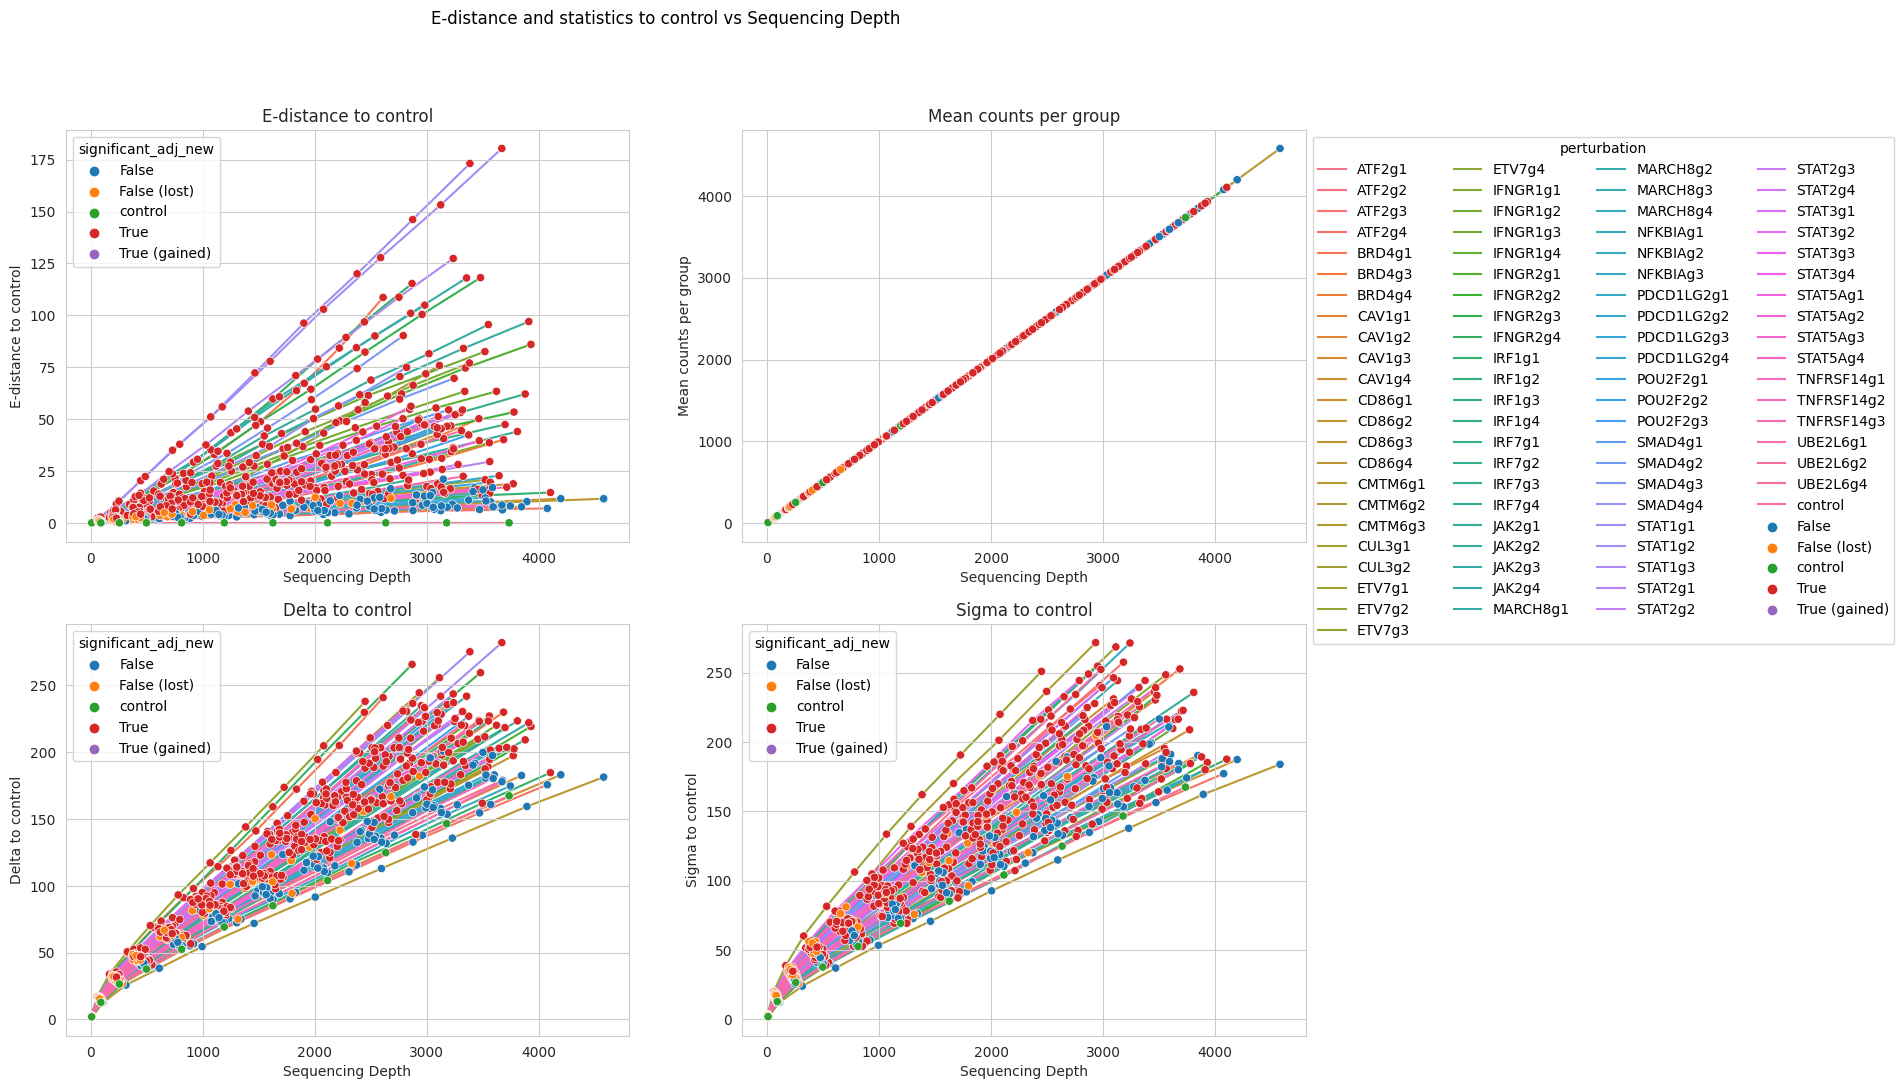

In [217]:
x = 'ncounts'
xlabel = 'Sequencing Depth'

with sns.axes_style('whitegrid'):
    fig, axs = pl.subplots(2, 2, figsize=(8*2,6*2), dpi=100)
lineplot_kwargs = dict(hue=groupby, color='grey', x=x, zorder=-1)
scatterplot_kwargs = dict(hue='significant_adj_new', marker="o", x=x)

for y, ax, title in zip(['edist', 'ncounts', 'delta', 'sigma'],
                        np.ravel(axs),
                        [f'E-distance to {control}', 'Mean counts per group', f'Delta to {control}', f'Sigma to {control}']
                       ):
    plot=sns.lineplot(data=sdf, ax=ax, y=y, legend=ax==axs[0,-1], **lineplot_kwargs)
    sns.scatterplot(data=sdf, ax=ax, y=y, **scatterplot_kwargs)
    ax.set_ylabel(title)
    ax.set_title(title)
    ax.set_xlabel(xlabel)
    
    # merge tight legend
    if y=='ncounts':
        h,l = plot.axes.get_legend_handles_labels()
        plot.axes.legend_.remove()
        ax.legend(h,l, ncol=4, bbox_to_anchor=(1,1), title=groupby)

pl.suptitle(f'E-distance and statistics to {control} vs {xlabel}')
pl.savefig(f'../{dataset}_ncounts_complete.pdf', bbox_inches='tight')
pl.show()